# 패키지

In [1]:
import os                           # 운영체제
import time                         # 시간
import tensorflow as tf             # 텐서플로
import tensorflow_addons as tfa     # 텐서플로 에드온
import pandas as pd                 # 판다스
import matplotlib.pyplot as plt     # 그래프 도구
import MSRL                         # Musical Symbol Recognition Library

c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

# GPU 설정

In [2]:
# 사용 가능한 모든 GPU 리스트
gpus = tf.config.list_physical_devices('GPU')

# 사용할 프로세서 선택 : GPU
if gpus:
    try: tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: print(e)

# 학습 준비

In [3]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()

# 모델
msModel = MSRL.models.MusicalSymbolModel()

# 모델 Object Detection

In [4]:
# 모델 주소
model_OD_dir = os.path.join('.', 'models', 'model_OD.h5')
model_OD_epoch_dir = os.path.join('.', 'models', 'model_OD-{epoch}.h5')
tensorboard_OD_dir = os.path.join('.', 'model_TB', 'model_OD', time.strftime("%Y_%m_%d-%H_%M_%S"))

# 모델 콜백 함수
cb_checkpoint_OD = tf.keras.callbacks.ModelCheckpoint(model_OD_epoch_dir, monitor='loss', save_best_only=True)
cb_early_stop_OD = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
cb_tensorboard_OD = tf.keras.callbacks.TensorBoard(tensorboard_OD_dir)

# 데이터셋 준비
ds_OD_train, ds_OD_validation, ds_OD_test = msDataset.ds_OD()

-- TFDS Train ------------------
input  : (20000,), <dtype: 'string'>
output : (20000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12384, 9915, 11272, 7575, 9942, 12213, 10637, 11760]

-- TFDS Validation ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1253, 984, 1123, 753, 997, 1240, 1058, 1195]

-- TFDS Test ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1223, 979, 1108, 774, 977, 1229, 1068, 1138]



In [5]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 생성
    model_OD = msModel.model_OD2() 

    # 모델 컴파일 설정
    model_OD.compile(
        optimizer=tf.keras.optimizers.Adam(), # 1e-3에서 1e-4로 학습률 조정 조정 : learning_rate=1e-3, clipnorm=1.0
        loss=MSRL.losses.WeightedMultiTaskLoss(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]),
        metrics=[
            MSRL.metrics.Accuracy(),     # 정확도
            MSRL.metrics.HammingScore(), # 해밍 점수
            MSRL.metrics.IoU(512, 192)   # IoU 점수 평균
        ]
    )

    # 모델 훈련
    history_OD = model_OD.fit(
        ds_OD_train,
        epochs=20,
        initial_epoch=0,
        validation_data=ds_OD_validation,
        callbacks=[cb_checkpoint_OD, cb_early_stop_OD, cb_tensorboard_OD]
    )

    # 현재까지 학습된 모델 저장
    model_OD.save(model_OD_dir)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_OD --port=6006

Epoch 1/20
625/625 [==============================] - 194s 274ms/step - loss: 7.8217 - Accuracy: 0.3259 - HammingScore: 0.8587 - IoU: 0.1403 - val_loss: 16.7275 - val_Accuracy: 0.0250 - val_HammingScore: 0.7207 - val_IoU: 0.0887
Epoch 2/20
625/625 [==============================] - 166s 266ms/step - loss: 5.2043 - Accuracy: 0.5354 - HammingScore: 0.9317 - IoU: 0.1883 - val_loss: 40.0941 - val_Accuracy: 0.0125 - val_HammingScore: 0.6357 - val_IoU: 0.0851
Epoch 3/20
625/625 [==============================] - 165s 264ms/step - loss: 3.9670 - Accuracy: 0.6808 - HammingScore: 0.9601 - IoU: 0.2250 - val_loss: 7.4024 - val_Accuracy: 0.6200 - val_HammingScore: 0.9488 - val_IoU: 0.0692
Epoch 4/20
625/625 [==============================] - 165s 264ms/step - loss: 3.3539 - Accuracy: 0.7547 - HammingScore: 0.9715 - IoU: 0.2482 - val_loss: 9.7788 - val_Accuracy: 0.5275 - val_HammingScore: 0.9298 - val_IoU: 0.0620
Epoch 5/20
625/625 [==============================] - 165s 264ms/step - loss: 3.0159 -

In [5]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 불러오기
    model_OD = tf.keras.models.load_model(model_OD_dir, compile=False)

    # 모델 컴파일 설정
    model_OD.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=MSRL.losses.WeightedMultiTaskLoss(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]),
        metrics=[
            MSRL.metrics.Accuracy(),                # 정확도
            MSRL.metrics.HammingScore(),            # 해밍 점수
            MSRL.metrics.IoU(512, 192),             # IoU 점수 평균
            MSRL.metrics.PointDistance(512, 192)    # 중심 좌표 차이
        ]
    )

    # 모델 훈련
    history_OD = model_OD.fit(
        ds_OD_train,
        epochs=40,
        initial_epoch=20,
        validation_data=ds_OD_validation,
        callbacks=[cb_checkpoint_OD, cb_early_stop_OD, cb_tensorboard_OD]
    )

    # 현재까지 학습된 모델 저장
    model_OD.save(model_OD_dir)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_OD --port=6006

Epoch 21/40
625/625 [==============================] - 191s 269ms/step - loss: 1.2595 - Accuracy: 0.8920 - HammingScore: 0.9888 - IoU: 0.4780 - PointDistance: 17.0906 - val_loss: 2.6394 - val_Accuracy: 0.7420 - val_HammingScore: 0.9718 - val_IoU: 0.3828 - val_PointDistance: 20.6886
Epoch 22/40
625/625 [==============================] - 163s 261ms/step - loss: 1.1654 - Accuracy: 0.9071 - HammingScore: 0.9905 - IoU: 0.4869 - PointDistance: 16.3683 - val_loss: 3.7659 - val_Accuracy: 0.6685 - val_HammingScore: 0.9570 - val_IoU: 0.2095 - val_PointDistance: 42.5820
Epoch 23/40
625/625 [==============================] - 163s 261ms/step - loss: 1.0742 - Accuracy: 0.9136 - HammingScore: 0.9913 - IoU: 0.5009 - PointDistance: 15.5674 - val_loss: 1.4469 - val_Accuracy: 0.8905 - val_HammingScore: 0.9885 - val_IoU: 0.3934 - val_PointDistance: 22.9085
Epoch 24/40
625/625 [==============================] - 163s 261ms/step - loss: 1.0305 - Accuracy: 0.9162 - HammingScore: 0.9915 - IoU: 0.5109 - PointDi

# 학습 결과

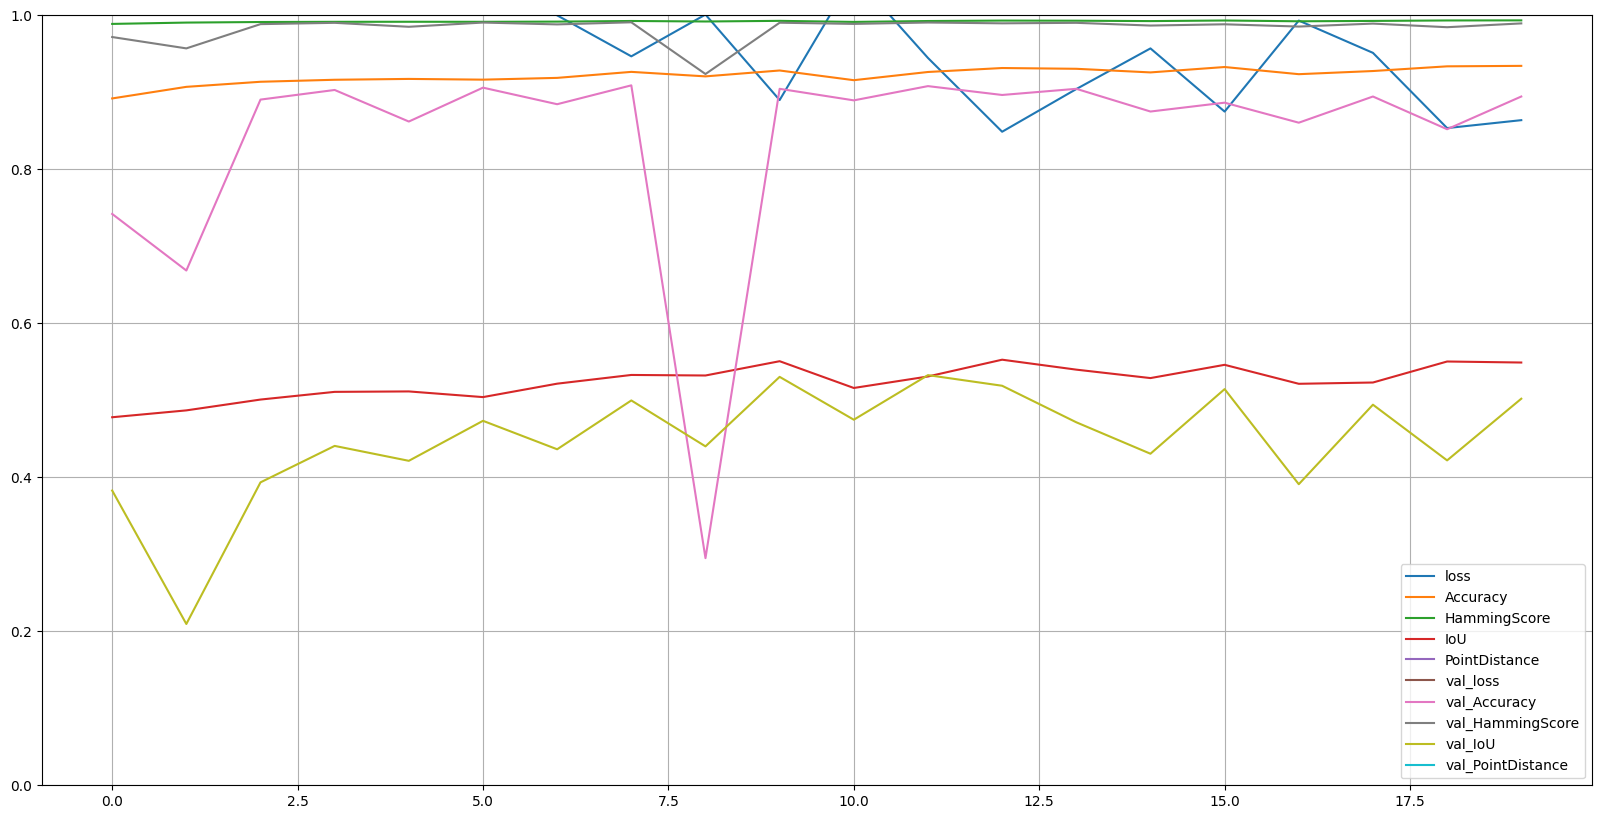

In [6]:
# model_YOLO 훈련 결과 그리기
pd.DataFrame(history_OD.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()